In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.constants import Planck
from scipy.constants import speed_of_light
#import pandas as pd
#df=pd.read_csv('Part II/-5_B7.5/F0000CH2.csv', sep=',', header = None)
#print(df)

In [2]:
I_sat=4.1 #mW/cm^2, Saturation Intensity taken from F20.pdf page 82
lw=2*np.pi*6.07 #MHz, Natural Line Width of RB 85 (what about 87?) taken from F20.pdf page 82
Trans=0.96 #a.u., Transmission of the optical viewport taken from F20.pdf page 83
radius=25.4 #mm, radius of the collecting lense taken from F20.pdf page 83
distance=150 #mm, distance between MOT and Photodiode taken from F20.pdf page 83
G=4.75e6 #V/A, Gain of Photdiode amplifier at +70dB taken from F20.pdf page 83
Gf=G*0.05 #V/A, Error of G taken from F20.pdf page 83
QE=0.52 #A/W, Quantum Efficiency of the sensor taken from F20.pdf page 83
QEf=0.015 #A/W, Error of QE taken from F20.pdf page 83
S=1e6/(1e6+50) #a.u., Scale Factor cause by impedance difference taken from F20.pdf page 83
sp_85=384.230406373e12 #Hz, S->P transition for RB85 taken from F20.pdf page 19
sf3_85=1.264888e9 #Hz, deltaF in S for F=3 for RB85 taken from F20.pdf page 19
pf2_85=83.835e6 #Hz, deltaF in P for F=2 for RB85 taken from F20.pdf page 19
pf4_85=100.205e6 #Hz, deltaF in P for F=4 for RB85 taken from F20.pdf page 19
powerx=8 #mW, Laserpower in x direction
powery=8 #mW, Laserpower in y direction
powerz=18 #mW, Laserpower in z direction
omega=0.2 #cm, width of Laser Beam taken from F20.pdf page 83
amount=2500 #data sets per .csv
red_amount=2250 # reduced data sets per .csv
detuning=([5,6,7,8,10,12,14,16]) #array for indexing detuning
#arrays for current indexing current
current75=([0,4,8,12,16,20,24,29]) 
current8=([1,5,9,13,17,21,25,30])
current85=([2,6,10,14,18,22,27,31])
current9=([3,7,11,15,19,23,28,32])
#linspace for Loadingtime plot
tplot=np.linspace(0,5,5000)

In [3]:
#defining constant fit function for background noise
def con(x,b): 
    return 0*x+b

#defining loadingTime fit
def loadingTime(time,L,alpha,tshift):
        nload = L/alpha*(1-np.exp(-alpha*(time-tshift)))
        return nload

#defining laserintensity
def I_r():
    return 2*(powerx+powery+powerz)/(np.pi*omega**2)

#defining solid angle theta for conversion
def theta():
    return radius**2/(4*distance**2)

#defining scatteringRate for conversion
def scatteringRate(detuning):
    I_0 = I_r()
    resultScatteringRate = 1e6*(lw/2)*(I_0/I_sat)/(1+I_0/I_sat+4*detuning**2/lw**2)
    return resultScatteringRate

#defining wavelength with detuning for conversion
def wavelength(detuning):
    return speed_of_light/(sp_85-sf3_85+(pf4_85-pf2_85)/2-detuning*1e6)
#KEEP IN MIND: value is taken from second explanation on page 68 from F20.pdf

#defining energy from a phton with wavelength(detuning) for conversion
def energy(detuning):
    energyCalc = Planck*speed_of_light/wavelength(detuning)
    return energyCalc

In [4]:
#reading out the csv and returning time and voltage as arrays
def grabData(file):
    #file is string with form :
    #'Part II/-<absolute detuning value>_B<value of the current>/F<# of csv with 4 digits>CH1.csv'
    #for example 'Part II/-6_B7.5/F0001.csv'
    dg = np.genfromtxt(file, delimiter=',')
    #6 dim array with most of them being 'empty' caused by the way Oscilloscope writes the .csv
    #Example of the first 3 'lines', column 0 and 1 become NaN as well after 17 lines
#                   0                   1   2      3     4   5
#0        Record Length        2.500000e+03 NaN  0.000  3.04 NaN
#1      Sample Interval        1.000000e-03 NaN  0.001  3.02 NaN
#2        Trigger Point  0.000000000000e+00 NaN  0.002  3.02 NaN
    g0,g1,g2,g3,g4,g5 = np.hsplit(dg,6)
    #g3=time, g4=voltage
    return g3,g4

#translating voltage into #atoms
def conversion(voltage,detuning):
    scat = scatteringRate(detuning)
    eng = energy(detuning)
    angle = theta()
    natoms = voltage/(QE*G*S*Trans*angle*scat*eng)
    return natoms

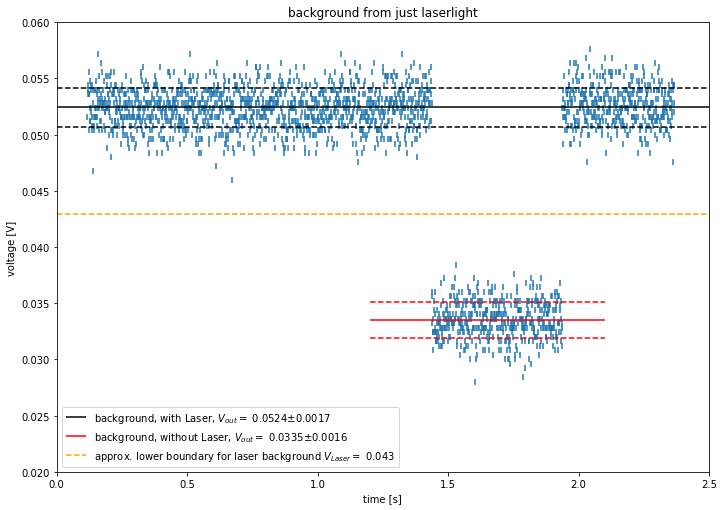

In [5]:
#Determinging the Background being measured by the ccd with and without laser
t0b, background = grabData('Part II/Background/F0033CH1.csv') #change folder 'Part II if needed'
#filtering 250 values
t1b = t0b[np.where(background > 0.025)]
back = background[np.where(background > 0.025)]
#ubb = background with laser (ubackgroundbright) in V
#xbb = t0b[np.where(background > 0.043)]
ybb = background[np.where(background > 0.043)]
#ubb, fbb = curve_fit(con,xbb,ybb)
ubb = np.mean(ybb)
ubb_f = np.std(ybb)
#ubd = background without laser (ubackgrounddark) in V
xb = t0b[np.where(background < 0.043)]
yb = background[np.where(background < 0.043)]
#xbd = xb[np.where(yb > 0.025)]
ybd = yb[np.where(yb > 0.025)]
#ubd, fbd = curve_fit(con,xbd,ybd)
ubd = np.mean(ybd)
ubd_f = np.std(ybd)
#plot background means
xlin=np.arange(4)
plt.scatter(t1b,back,marker="|")
#plt.plot(xlin,con(xlin,ubb),'green',linestyle='--',label='Background, with Laser, $V_{out}=$'+str(np.round(ubb,4)))
plt.hlines(ubb,0,2.5,'black',
label='background, with Laser, $V_{out}=$ '+str(np.round(ubb,4))+'$\pm$'+str(np.round(ubb_f,4)))
plt.hlines(ubb+ubb_f,0,2.5,'black','--')
plt.hlines(ubb-ubb_f,0,2.5,'black','--')
#plt.plot(xlin,con(xlin,ubd),'red',linestyle='--',label='Background, no Laser, $V_{out}=$'+str(np.round(ubd,4)))
plt.hlines(ubd,1.2,2.1,'red',
label='background, without Laser, $V_{out}=$ '+str(np.round(ubd,4))+'$\pm$'+str(np.round(ubd_f,4)))
plt.hlines(ubd+ubd_f,1.2,2.1,'red','--')
plt.hlines(ubd-ubd_f,1.2,2.1,'red','--')
#approx for background filter
approx = 0.5*(ubb+ubd)
plt.hlines(approx,0,2.5,'orange','--',label='approx. lower boundary for laser background $V_{Laser}=$ '+str(np.round(approx,4)))
#cosmetics
plt.xlabel('time [s]')
plt.ylabel('voltage [V]')
plt.legend(loc='lower left')
plt.xlim(0,2.5)
plt.ylim(0.02,0.06)
plt.title('background from just laserlight')
plt.gcf().set_size_inches(11.69, 8.27)
plt.show()

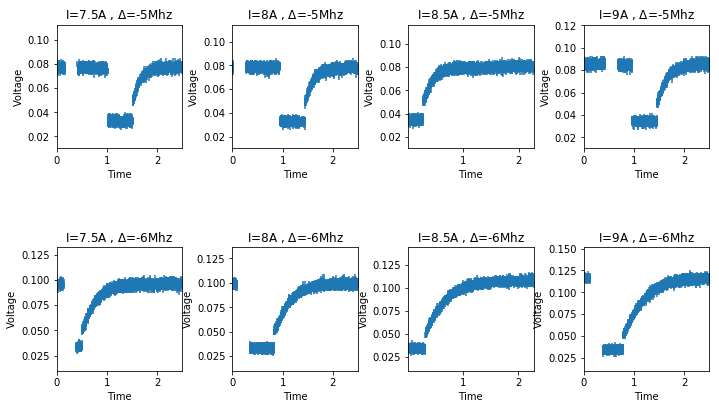

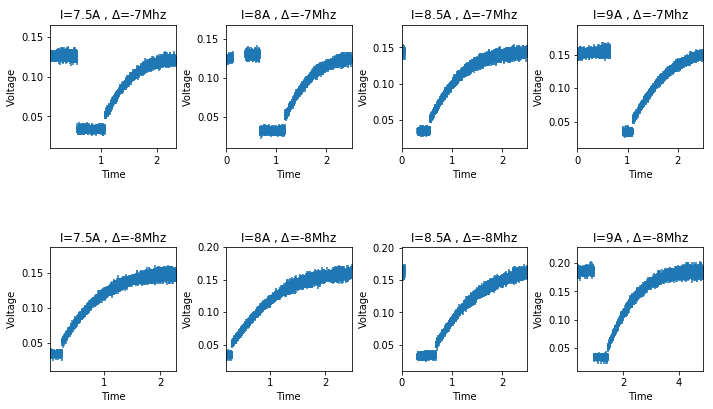

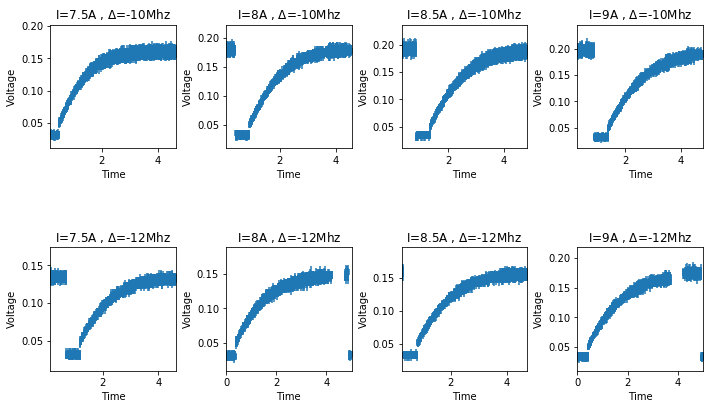

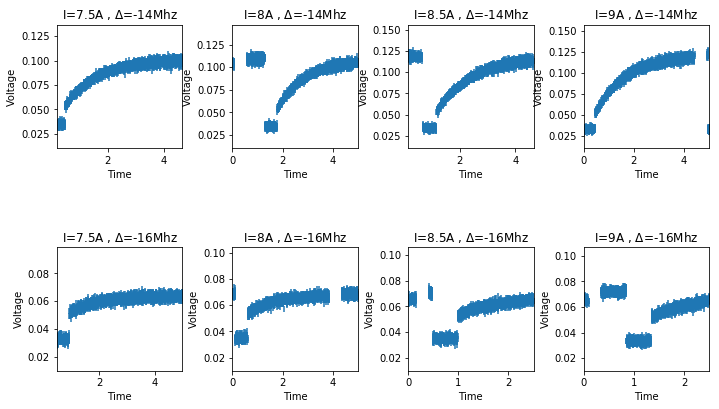

In [6]:
#Reading out all 33 Files, we skip one file so we end up with 32
#create empty array that we fill, when called it gives back data according to: 
#array[file index(0-31),value(0-2499),specify(0-2)] specify: 0=detuning[MHz], 1=current[A], 2=value
n=32 #n+1=amount of csv files
narr=np.arange(n+1,dtype=int) #array for loop
t_all = np.empty((n,amount,3))
u_all = np.empty((n,amount,3))
for i in narr: 
    if(i==0): j=1
    if(i==26): continue #removed cause we have this data set 2 times and this one was worse
    #building the string to read next file 
    #part I: F<4 digits number of .csv starts at 0000>
    if(i<10):
        c='F000'+str(i)
    else:
        c='F00'+str(i)
    #part II: <value of current> and adding counter for current for array
    if(i in current75):
        b='7.5'
        r=7.5
    if(i in current8):
        b='8'
        r=8
    if(i in current85):
        b='8.5'
        r=8.5
    if(i in current9):
        b='9'
        r=9
    #part III: <abolsute detuning value> and adding counter for detuning for array
    if(i<4):
        a=str(5)
        z=detuning[0]
    elif(i<8):
        a=str(6)
        z=detuning[1]
    elif(i<12):
        a=str(7)
        z=detuning[2]
    elif(i<16):
        a=str(8)
        z=detuning[3]
    elif(i<20):
        a=str(10)
        z=detuning[4]
    elif(i<24):
        a=str(12)
        z=detuning[5]
    elif(i<29):
        a=str(14)
        z=detuning[6]
    else:
        a=str(16)
        z=detuning[7]
    #patching together the actual path
    path = 'Part II/-'+a+'_B'+b+'/'+c+'CH1.csv' 
    t,u = grabData(path)
    #everything up till here was just to read out the .csv
    #filling the arrays with i==26 exception rule
    if(i<26):
        u_all[i,:]=u
        u_all[i,:,1]=r
        u_all[i,:,0]=z
        t_all[i,:]=t
        t_all[i,:,1]=r
        t_all[i,:,0]=z
    else:
        u_all[i-1,]=u 
        u_all[i-1,:,1]=r
        u_all[i-1,:,0]=z
        t_all[i-1,:]=t
        t_all[i-1,:,1]=r
        t_all[i-1,:,0]=z
    #drawing the subplots of just data while leaving "error" signals below 0.025V out 
    t = t[np.where(u > 0.025)]
    u = u[np.where(u > 0.025)] 
    plt.subplot(2,4,j)
    plt.scatter(t,u,marker="|") 
    plt.xlim(t[0],t[-1])
    ymax=np.amax(u)+0.03
    plt.ylim(0.01,ymax)
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title('I='+b+'A , $\Delta$=-'+a+'Mhz')
    #every 8 subplots = 1 picture
    j=j+1
    if(j>8): 
        plt.subplots_adjust(wspace=0.4,hspace=0.8)
        plt.gcf().set_size_inches(11.69, 8.27/1.3)
        plt.show()
        j=1
    #clean up    
    del t,u,z,r,a,b,c,path

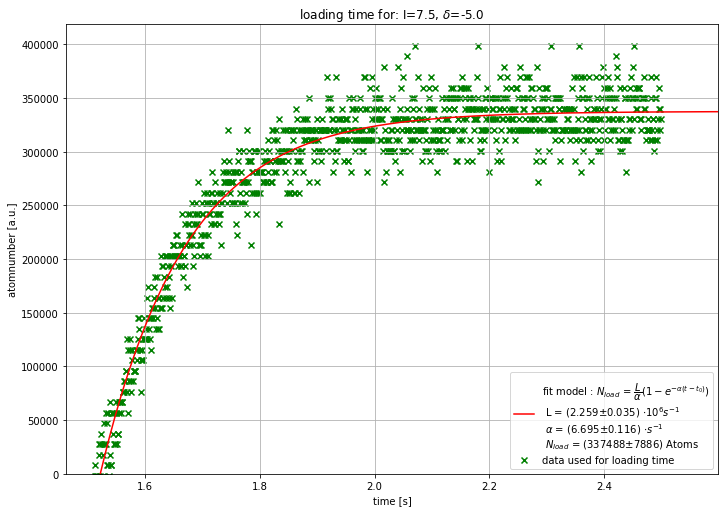

turn on time = 1.52 sec


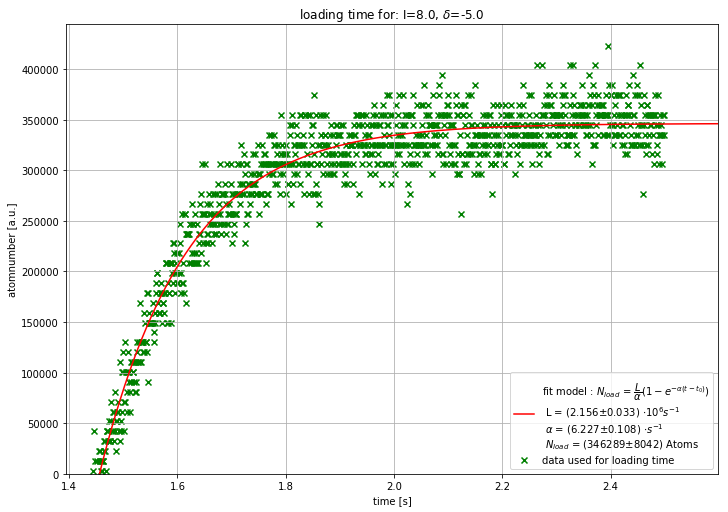

turn on time = 1.46 sec


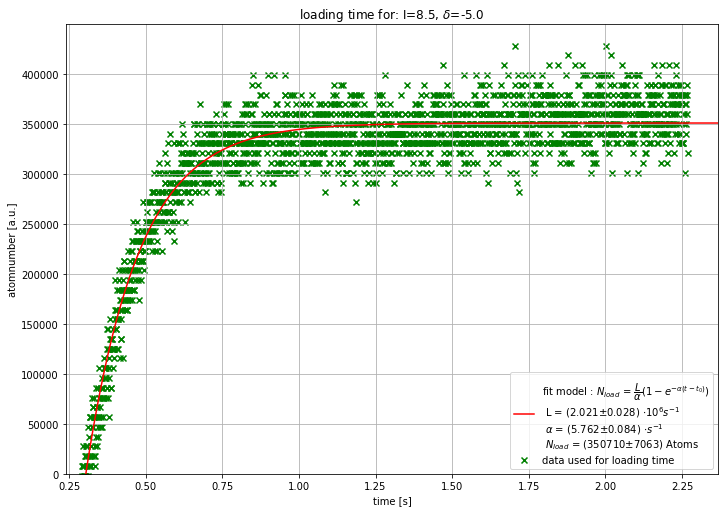

turn on time = 0.3 sec


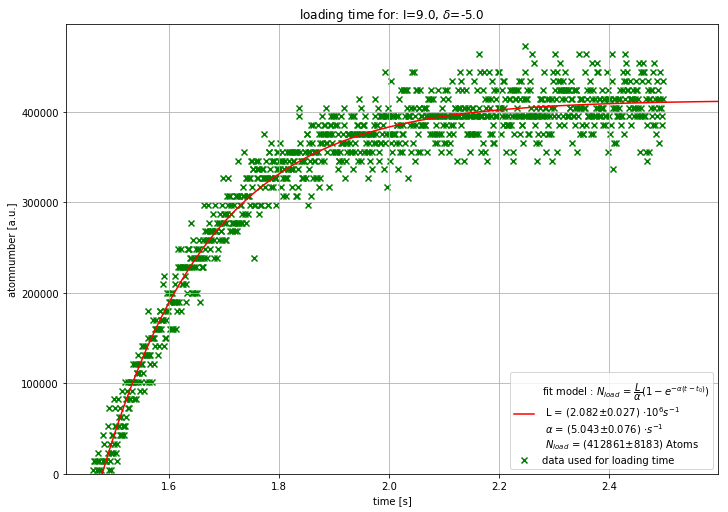

turn on time = 1.48 sec


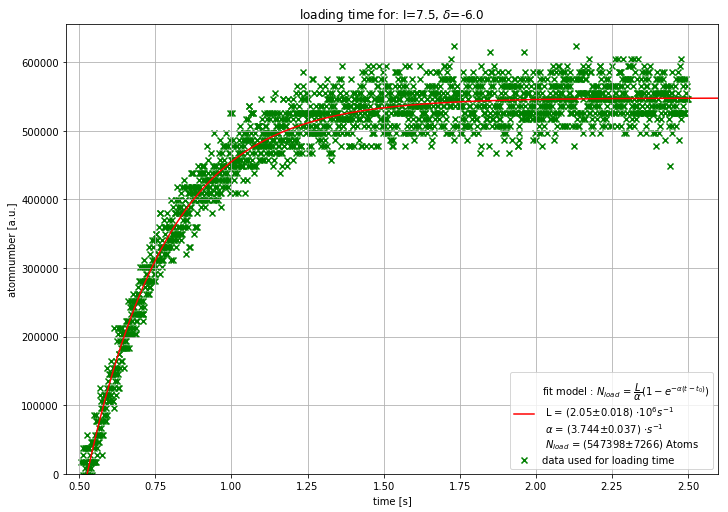

turn on time = 0.53 sec


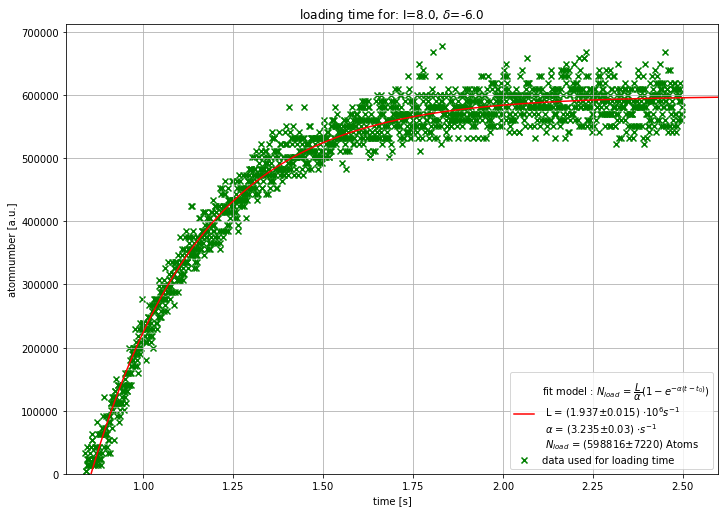

turn on time = 0.85 sec


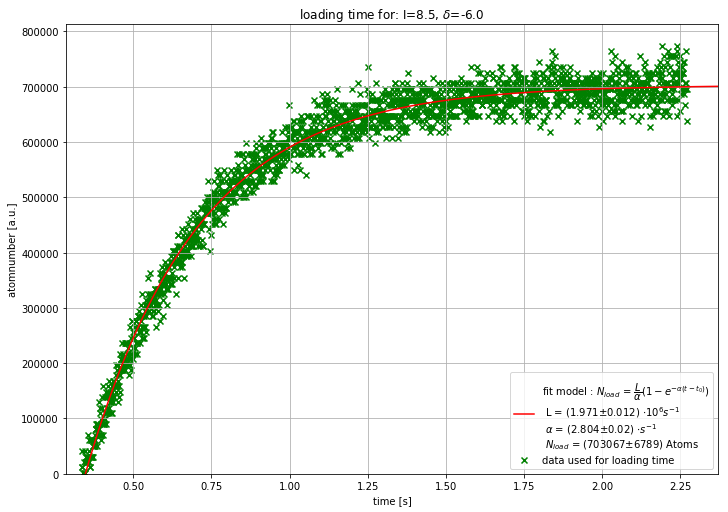

turn on time = 0.35 sec


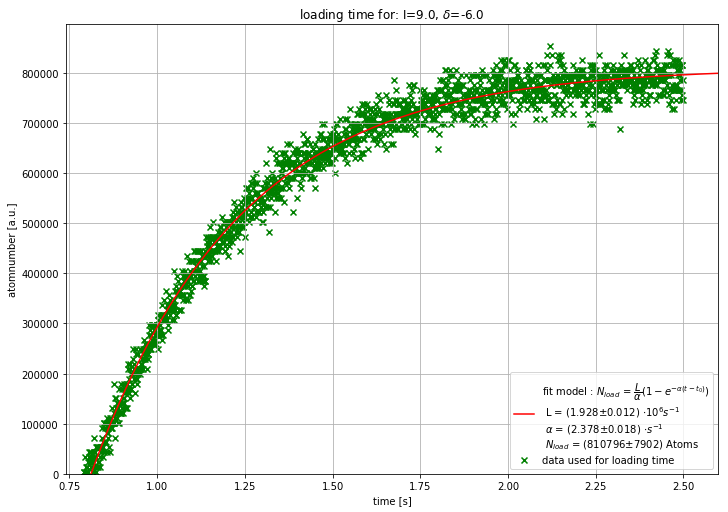

turn on time = 0.81 sec


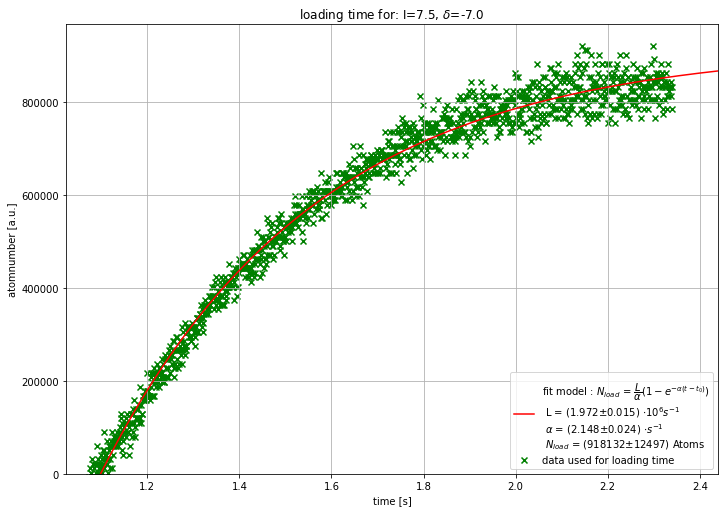

turn on time = 1.1 sec


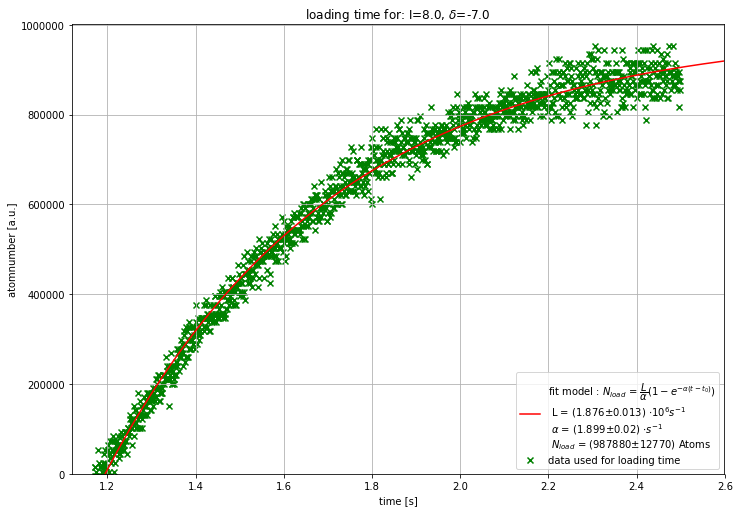

turn on time = 1.19 sec


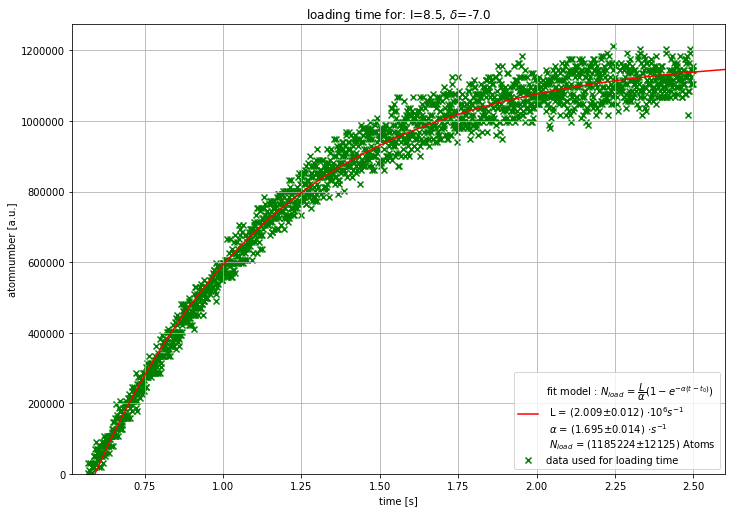

turn on time = 0.59 sec


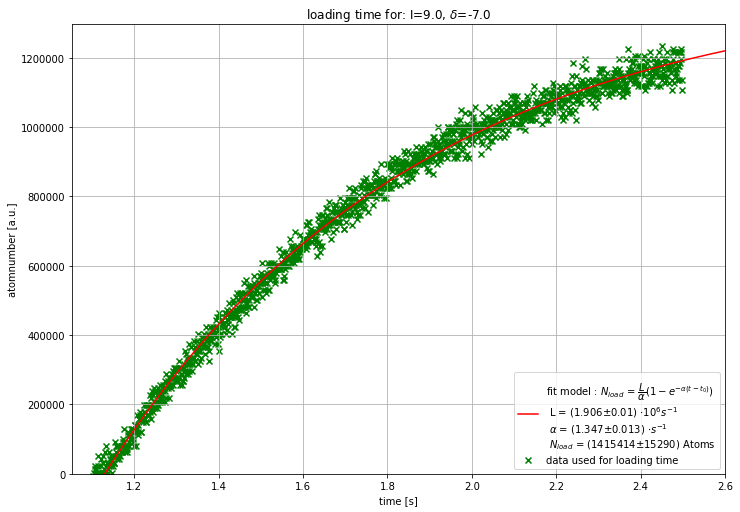

turn on time = 1.13 sec


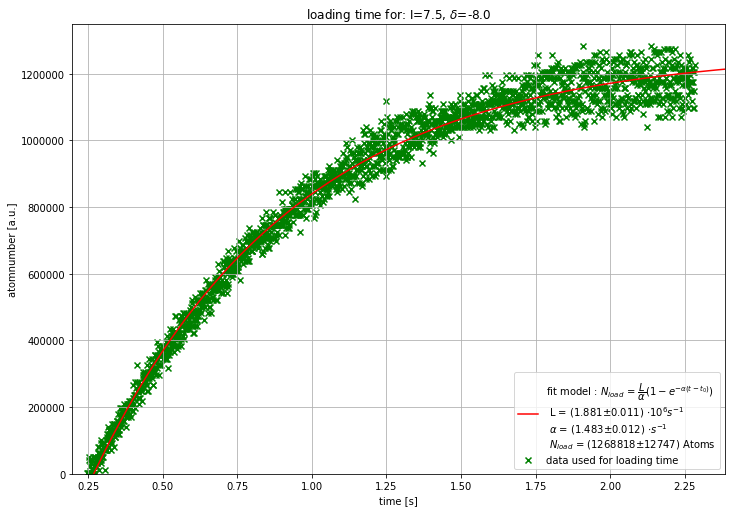

turn on time = 0.27 sec


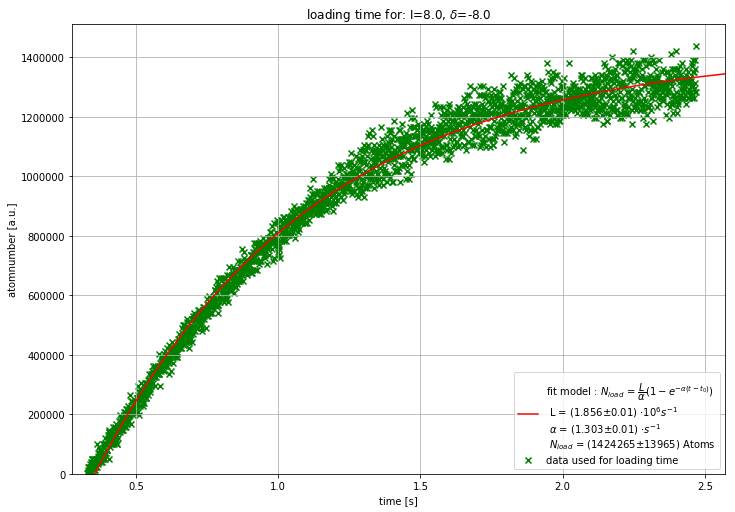

turn on time = 0.36 sec


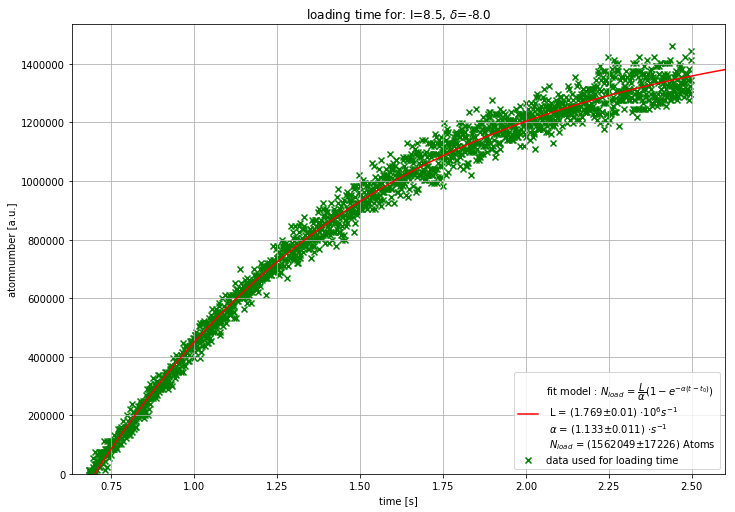

turn on time = 0.7 sec


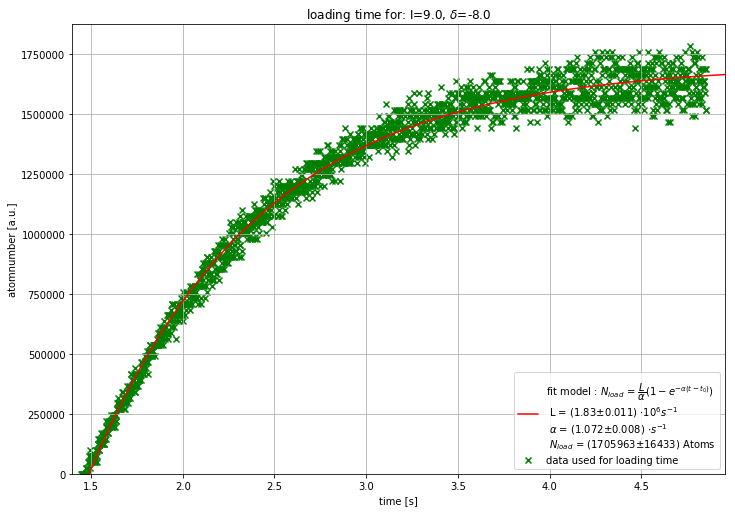

turn on time = 1.49 sec


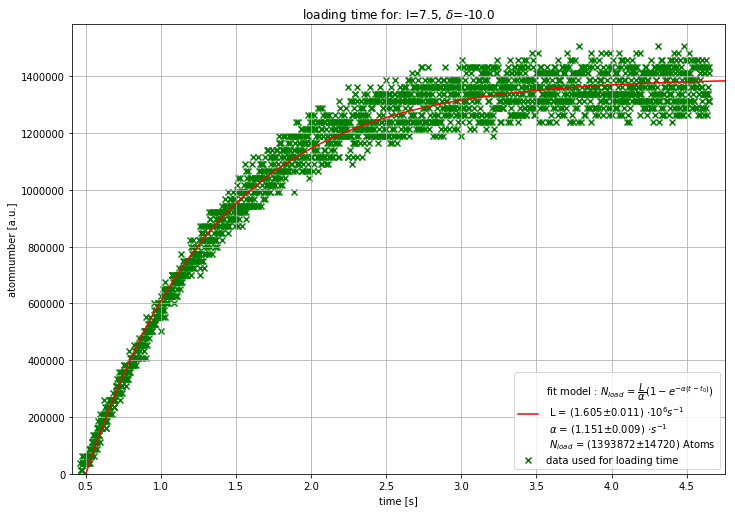

turn on time = 0.5 sec


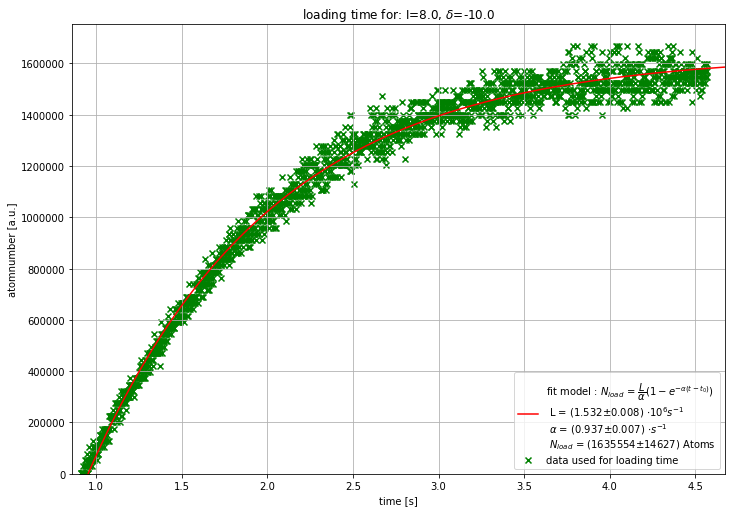

turn on time = 0.95 sec


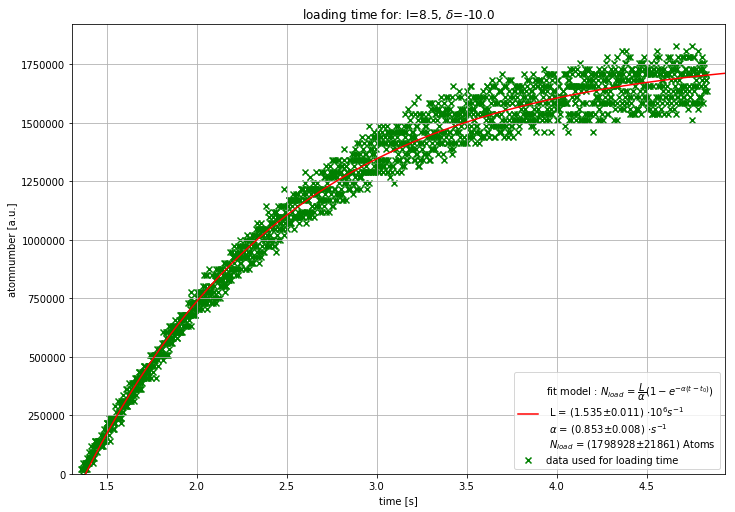

turn on time = 1.38 sec


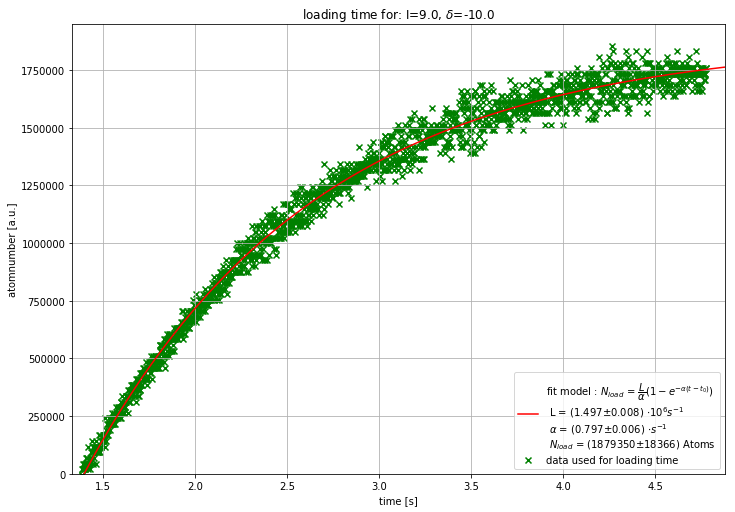

turn on time = 1.4 sec


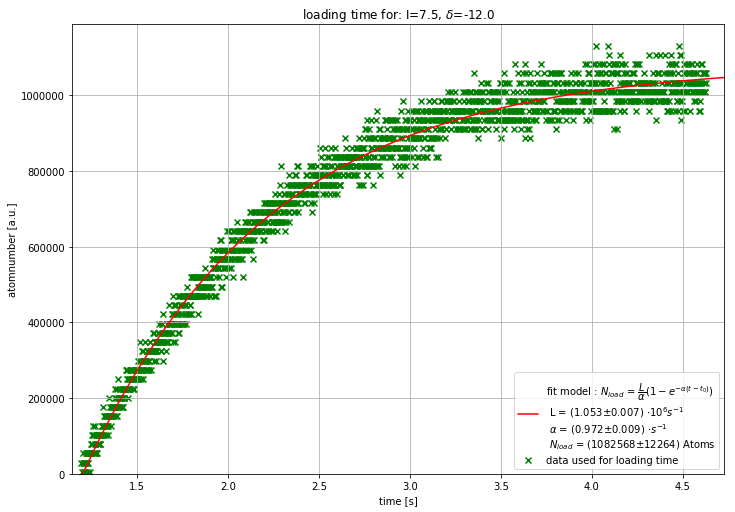

turn on time = 1.2 sec


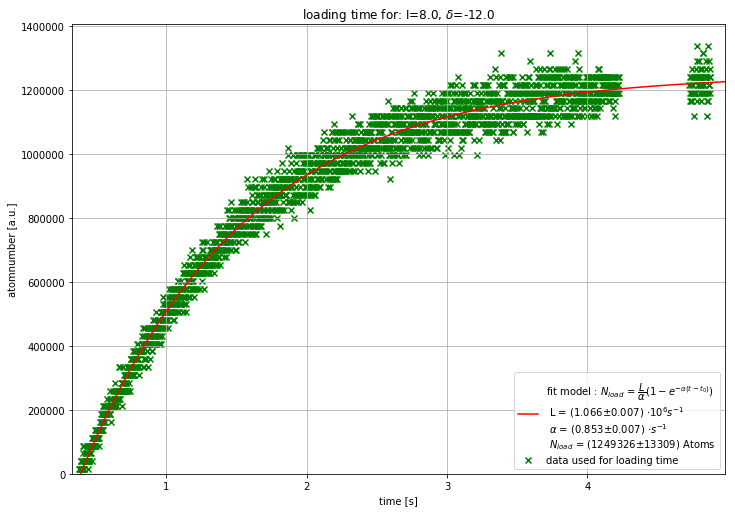

turn on time = 0.39 sec


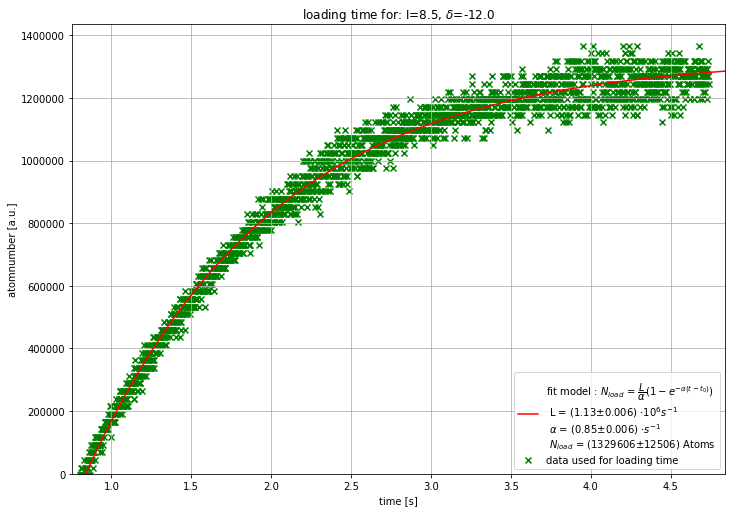

turn on time = 0.84 sec


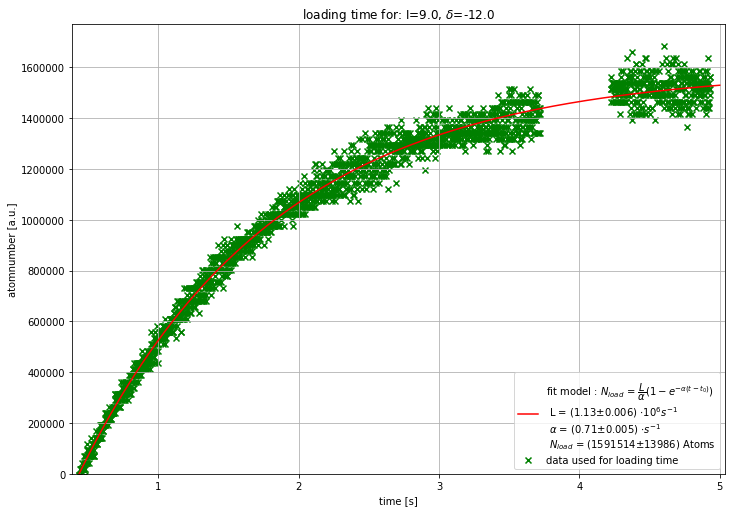

turn on time = 0.44 sec


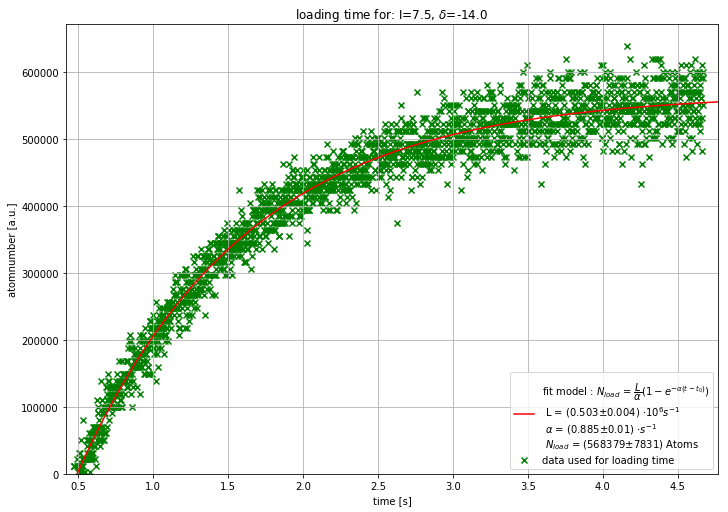

turn on time = 0.49 sec


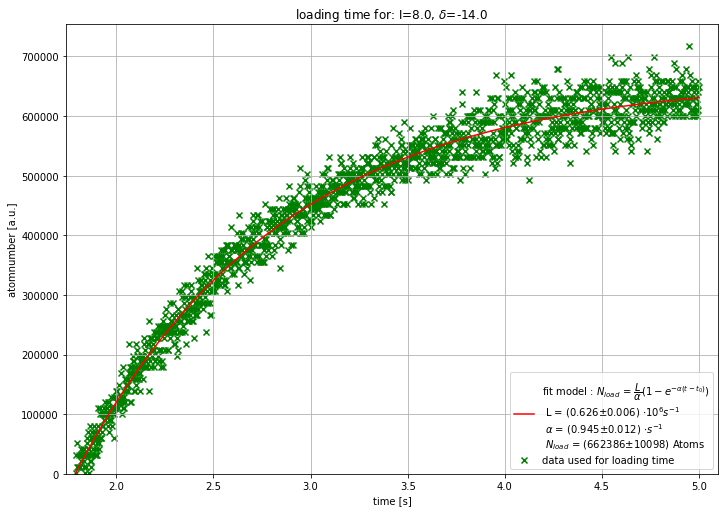

turn on time = 1.79 sec


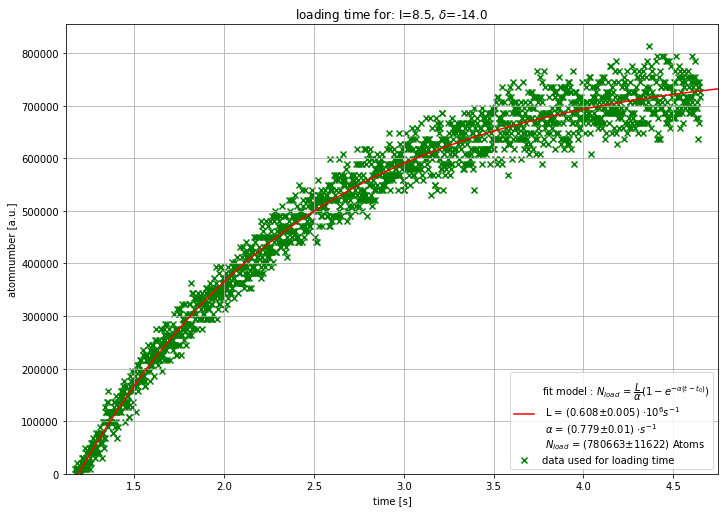

turn on time = 1.19 sec


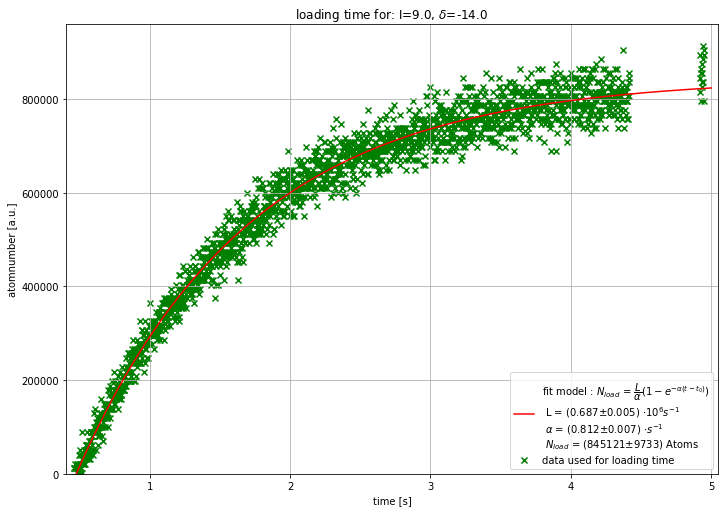

turn on time = 0.48 sec


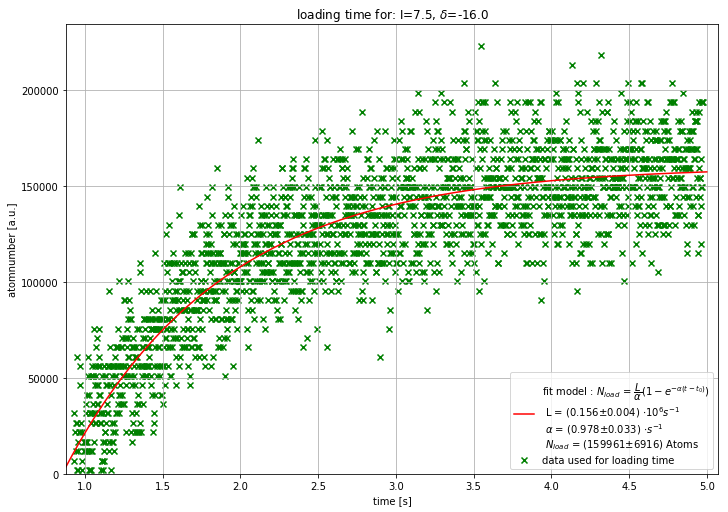

turn on time = 0.85 sec


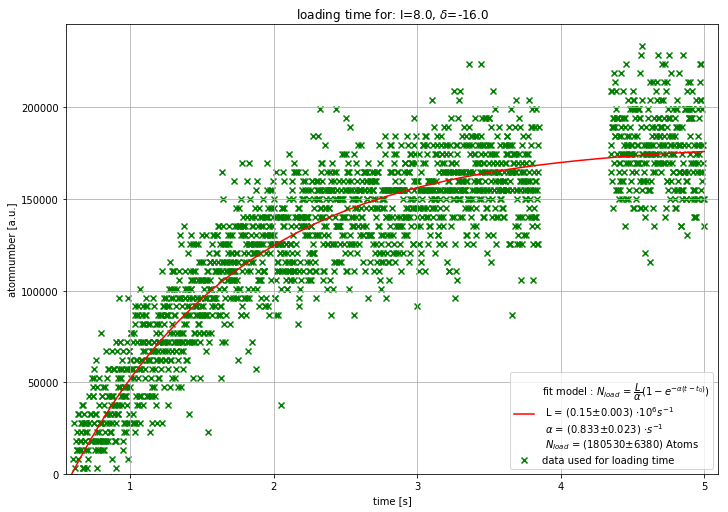

turn on time = 0.59 sec


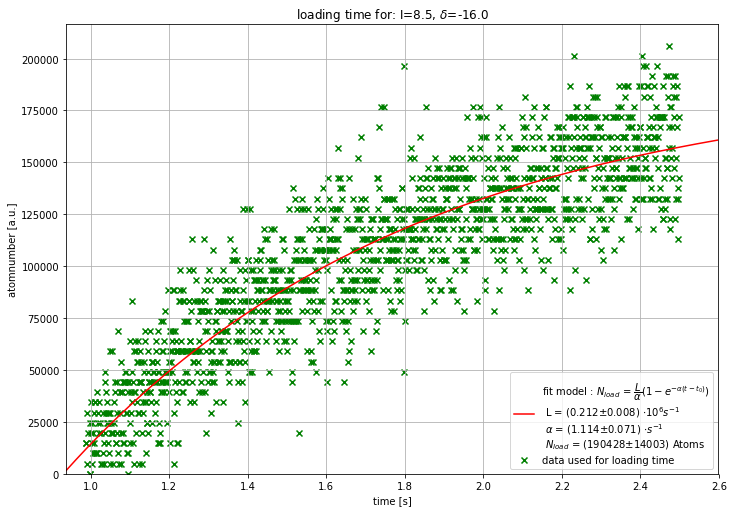

turn on time = 0.93 sec


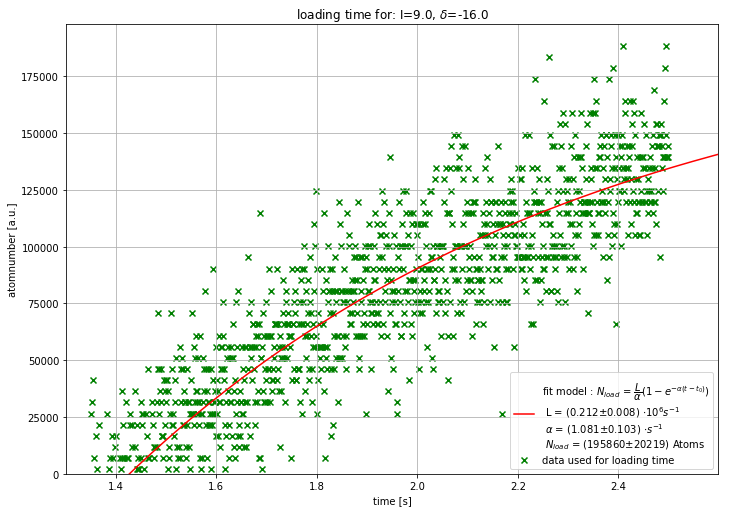

turn on time = 1.43 sec


In [12]:
#Loop goes till k
k=31 #k+1=actual amount of files used (not using detuning 16 as of now)
karr=np.arange(k+1,dtype=int) #array for another loop
l_all=np.empty((k+1,4))
a_all=np.empty((k+1,4))
n_all=np.empty((k+1,4))
for kn in karr:
    #saving tuning (tune) and current (curr) from current file
    tune=-t_all[kn,0,0]
    curr=t_all[kn,0,1]
    #create working arrays t_mod and u_mod
    t_mod=t_all[kn,:,2]
    u_mod=u_all[kn,:,2]
    #creating reduced array without error values (-250 data sets)
    t_red=t_mod[np.where(u_mod > 0.025)]
    u_red=u_mod[np.where(u_mod > 0.025)]
    #find out out where the "switch off" begins
    for amou in np.arange(red_amount,dtype=int):
        if(u_red[amou] < approx): break
    #start new array after "switch off" started
    u_temp=u_red[amou:]
    t_temp=t_red[amou:]
    #start new array after "switch on"
    u_temp2=u_temp[np.where(u_temp > approx)]
    t_temp2=t_temp[np.where(u_temp > approx)]
    #scaling amount of values for means depening on how much time between measurements
    #taking means out of the first 10 ms and last 20 to get mean atom number -> We use this one
    if t_mod[-1] < 2.6 :
        n_start = 10
        n_end = 20
    else:
        n_start = 5
        n_end = 10
    #converion to atom number
    #use '-np.mean(u_temp2[:10])' for zero callibration for each measurement, np.amin(n)=0
    n_temp = conversion(u_temp2-np.mean(u_temp2[:n_start]),tune)
    #use '-approx' if you wanna consider possible "remains" in MOT -> we use this
    #n_temp = conversion(u_temp2-approx,tune)
    #creating final arrays
    n=n_temp
    t=t_temp2
    #scattering final data sets
    plt.scatter(t,n,marker='x',color='green',label='data used for loading time')
    #creating fit for loading time
    load, loadf = curve_fit(loadingTime,t,n,p0=(1e6,1e-3,1))#,bounds=([1e-9,1e-4,-np.inf],[1e14,1e3,np.inf]))
    #creating errors for further analysis
    l_all[kn,:]=[load[0],np.sqrt(loadf[0][0]),tune,curr]
    a_all[kn,:]=[load[1],np.sqrt(loadf[1][1]),tune,curr]
    #n_mean=np.mean(n[-n_end:])-np.mean(n[:n_start])
    #n_error=np.sqrt(np.std(n[-n_end:])**2+np.std(n[:n_start])**2)
    #could also use L/a for atom number, if we use zero callibration np.amin(n)=0
    n_mean=load[0]/load[1]
    n_error=np.sqrt((np.sqrt(loadf[0][0])/load[1])**2+(np.sqrt(loadf[1][1])*load[0]/load[1]**2)**2)
    n_all[kn,:]=[n_mean,n_error,tune,curr]
    plt.plot(tplot,loadingTime(tplot,*load),color='red',label='\n'.join([
    r'fit model : $N_{load}$ = $\dfrac{L}{\alpha}(1-e^{-\alpha(t-t_0)})$',
    ' L = ('+str(np.round(load[0]/1e6,3))+'$\pm$'+
        str(np.round(np.sqrt(loadf[0][0])/1e6,3))+') $\cdot 10^{6}s^{-1}$',
    r' $\alpha$ = ('+str(np.round(load[1],3))+
        '$\pm$'+str(np.round(np.sqrt(loadf[1][1]),3))+') $\cdot s^{-1}$',
    ' $N_{load}$ = ('+str(int(n_all[kn,0]))+'$\pm$'+str(int(n_all[kn,1]))+') Atoms']))
    #cosmetics for plots
    plt.xlim(t[0]-0.05,t[-1]+0.1)
    plt.ylim(0,np.amax(n_temp)*1.05)
    plt.legend(loc='lower right')
    plt.xlabel('time [s]')
    plt.ylabel('atomnumber [a.u.]')
    plt.title('loading time for: I='+str(curr)+', $\delta$='+str(tune))
    plt.gcf().set_size_inches(11.69, 8.27)
    plt.grid(True)
    plt.show()
    print('turn on time = '+ str(np.round(load[2],2))+' sec')
    #cleaning up
    del t_mod,u_mod,t_red,u_red,t_temp,u_temp,t_temp2,u_temp2,n_temp,t,n
    del amou,tune,curr,load,loadf,n_mean,n_error,n_start,n_end  

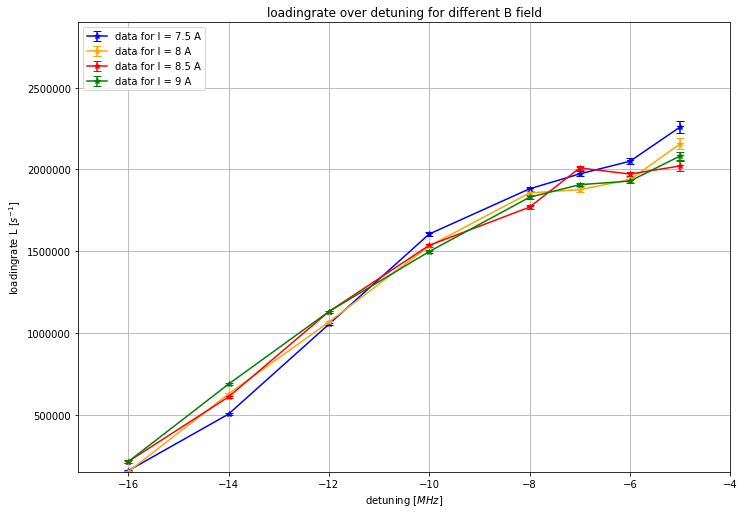

In [13]:
#Plotting the fitted loading rates over detuning with color dependencies on current
style = '*-'
cap=4
x75,x8,x85,x9,y75,y8,y85,y9,y75f,y8f,y85f,y9f=([] for i in range(12))
for di in enumerate(l_all):    
    if di[1][3] == 7.5:
        x75.append(di[1][2])
        y75.append(di[1][0])
        y75f.append(di[1][1])
    if di[1][3] == 8:
        x8.append(di[1][2])
        y8.append(di[1][0])
        y8f.append(di[1][1])
    if di[1][3] == 8.5:
        x85.append(di[1][2])
        y85.append(di[1][0])
        y85f.append(di[1][1])                
    if di[1][3] == 9:
        x9.append(di[1][2])
        y9.append(di[1][0])
        y9f.append(di[1][1])              
    if di[0] == k:
        plt.errorbar(x75,y75,yerr=y75f,color='blue',capsize=cap,fmt=style,label='data for I = 7.5 A')
        plt.errorbar(x8,y8,yerr=y8f,color='orange',capsize=cap,fmt=style,label='data for I = 8 A')
        plt.errorbar(x85,y85,yerr=y85f,color='red',capsize=cap,fmt=style,label='data for I = 8.5 A')
        plt.errorbar(x9,y9,yerr=y9f,color='green',capsize=cap,fmt=style,label='data for I = 9 A')
        plt.grid(True)
        plt.legend(loc='upper left')
        plt.xlabel('detuning [$MHz$]')
        plt.ylabel('loadingrate L [$s^{-1}$]')
        plt.gcf().set_size_inches(11.69, 8.27)
        plt.title('loadingrate over detuning for different B field')
        plt.xlim(-17,-4)
        plt.ylim(1.5e5,2.9e6)
        plt.show()
        del style,x75,x8,x85,x9,y75,y8,y85,y9,y75f,y8f,y85f,y9f,cap

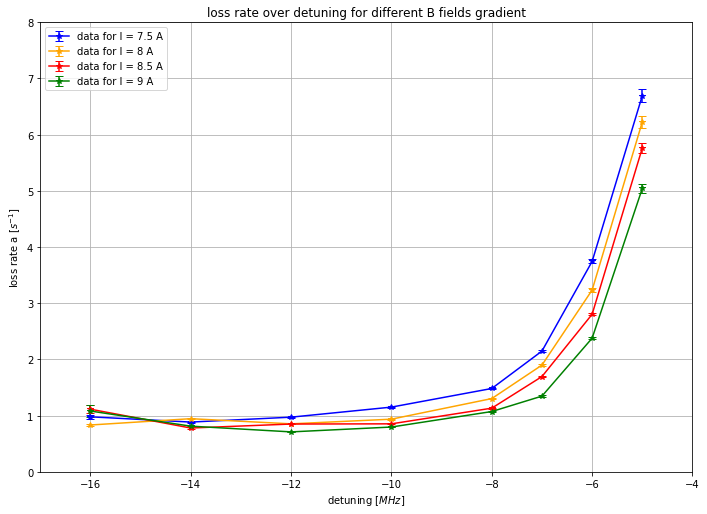

In [14]:
#Plotting the fitted loss rates over detuning with color dependencies on current
style = '*-'
cap = 4
x75,x8,x85,x9,y75,y8,y85,y9,y75f,y8f,y85f,y9f=([] for i in range(12))
for di in enumerate(a_all):    
    if di[1][3] == 7.5:
        x75.append(di[1][2])
        y75.append(di[1][0])
        y75f.append(di[1][1])
    if di[1][3] == 8:
        x8.append(di[1][2])
        y8.append(di[1][0])
        y8f.append(di[1][1])
    if di[1][3] == 8.5:
        x85.append(di[1][2])
        y85.append(di[1][0])
        y85f.append(di[1][1])                
    if di[1][3] == 9:
        x9.append(di[1][2])
        y9.append(di[1][0])
        y9f.append(di[1][1])              
    if di[0] == k:
        plt.errorbar(x75,y75,yerr=y75f,color='blue',capsize=cap,fmt=style,label='data for I = 7.5 A')
        plt.errorbar(x8,y8,yerr=y8f,color='orange',capsize=cap,fmt=style,label='data for I = 8 A')
        plt.errorbar(x85,y85,yerr=y85f,color='red',capsize=cap,fmt=style,label='data for I = 8.5 A')
        plt.errorbar(x9,y9,yerr=y9f,color='green',capsize=cap,fmt=style,label='data for I = 9 A')
        plt.grid(True)
        plt.legend(loc='upper left')
        plt.xlabel('detuning [$MHz$]')
        plt.ylabel('loss rate a [$s^{-1}$]')
        plt.gcf().set_size_inches(11.69, 8.27)
        plt.title('loss rate over detuning for different B fields gradient')
        plt.xlim(-17,-4)
        plt.ylim(0,8)
        plt.show()
        del style,x75,x8,x85,x9,y75,y8,y85,y9,y75f,y8f,y85f,y9f,cap

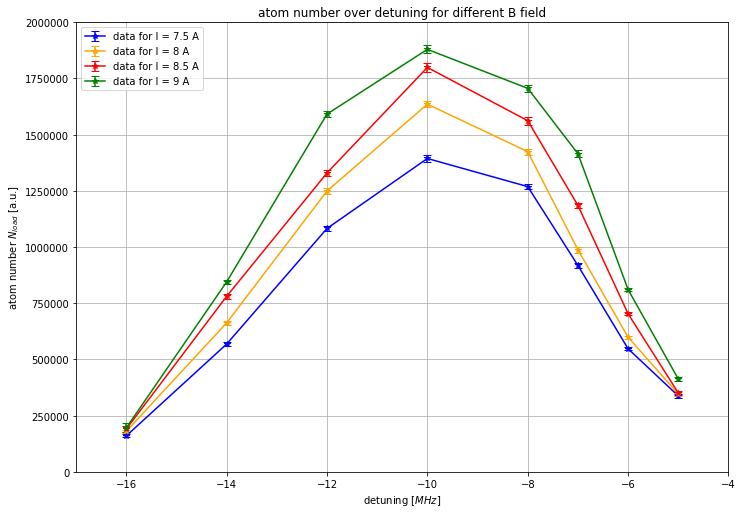

In [15]:
#Plotting the atom numbers over detuning with color dependencies on current
style = '*-'
cap = 4
x75,x8,x85,x9,y75,y8,y85,y9,y75f,y8f,y85f,y9f=([] for i in range(12))
for di in enumerate(n_all):    
    if di[1][3] == 7.5:
        x75.append(di[1][2])
        y75.append(di[1][0])
        y75f.append(di[1][1])
    if di[1][3] == 8:
        x8.append(di[1][2])
        y8.append(di[1][0])
        y8f.append(di[1][1])
    if di[1][3] == 8.5:
        x85.append(di[1][2])
        y85.append(di[1][0])
        y85f.append(di[1][1])                
    if di[1][3] == 9:
        x9.append(di[1][2])
        y9.append(di[1][0])
        y9f.append(di[1][1])              
    if di[0] == k:
        plt.errorbar(x75,y75,yerr=y75f,color='blue',capsize=cap,fmt=style,label='data for I = 7.5 A')
        plt.errorbar(x8,y8,yerr=y8f,color='orange',capsize=cap,fmt=style,label='data for I = 8 A')
        plt.errorbar(x85,y85,yerr=y85f,color='red',capsize=cap,fmt=style,label='data for I = 8.5 A')
        plt.errorbar(x9,y9,yerr=y9f,color='green',capsize=cap,fmt=style,label='data for I = 9 A')
        plt.grid(True)
        plt.legend(loc='upper left')
        plt.xlabel('detuning [$MHz$]')
        plt.ylabel('atom number $N_{load}$ [a.u.]')
        plt.gcf().set_size_inches(11.69, 8.27)
        plt.title('atom number over detuning for different B field')
        plt.xlim(-17,-4)
        plt.ylim(0,2000000)
        plt.show()
        del style,x75,x8,x85,x9,y75,y8,y85,y9,y75f,y8f,y85f,y9f,cap

Current : 7.5 A  -> B Gradient : 9.375 G/cm
Current : 8.0 A  -> B Gradient : 10.0 G/cm
Current : 8.5 A  -> B Gradient : 10.625 G/cm
Current : 9.0 A  -> B Gradient : 11.25 G/cm


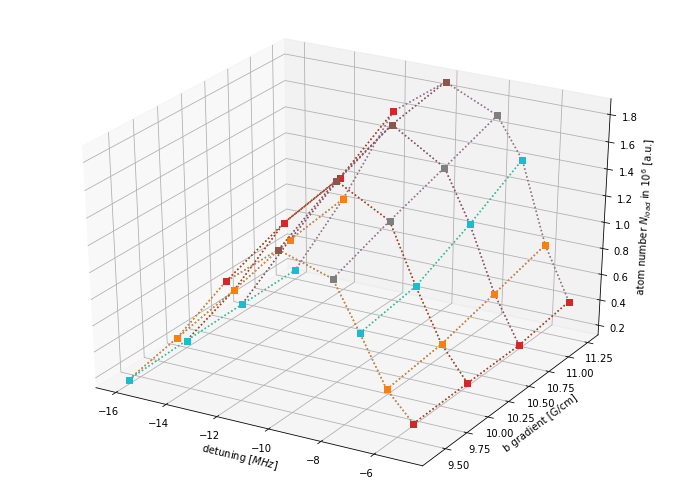

In [228]:
#3d plot of N, detuning, bfield gradient 
Bgrad=n_all[:,3]*1.25 #B-Field gradient calculation
style='s:' #plotstyle
#creating 3d plot
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
#plotting data with lines connecting them (atom number in 1e6)
for i in range(4):
    ax.plot(n_all[i::4,2],Bgrad[i::4],n_all[i::4,0]/1e6,style)
    ax.plot(n_all[i::4,2],Bgrad[i::4],n_all[i::4,0]/1e6,style)
for i in [28,24,20,16,12,8,4,0]:
    ax.plot(n_all[i:i+4,2],Bgrad[i:i+4],n_all[i:i+4,0]/1e6,style)
    ax.plot(n_all[i:i+4,2],Bgrad[i:i+4],n_all[i:i+4,0]/1e6,style)
#cosmetics
ax.set_xlabel('detuning [$MHz$]')
ax.set_ylabel('b gradient [G/cm]')
ax.set_zlabel('atom number $N_{load}$ in $10^{6}$ [a.u.]')
ax.set_top_view()
for i in range(4):
    print('Current : '+str(Bgrad[i]/1.25)+' A  -> B Gradient : '+str(Bgrad[i])+' G/cm')